<a href="https://colab.research.google.com/github/bzotec/ai-image-classification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#Convolutional Neural Network (Or CNN for short)
#used to classify images (MNIST datasets)

#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
#convert images to tensors
transform = transforms.ToTensor()

In [17]:
train_data  = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [18]:
#test data
test_data  = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [19]:
#batch size for images
train_loader= DataLoader(train_data, batch_size=10, shuffle=True)
test_loader= DataLoader(test_data, batch_size=10, shuffle=False)

In [20]:
# describe Convolutional Layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

# grab one MNIST record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [21]:
x = X_train.view(1, 1, 28, 28)

#perform 1st convolution
x = F.relu(conv1(x)) #rectified linear unit for activation function

In [22]:
#pass thru pooling layer
x = F.max_pool2d(x,2,2) # kernel of 2  stride of 2

In [23]:
# 2nd conv layer
x = F.relu(conv2(x))

In [24]:
# pooling
x= F.max_pool2d(x,2,2)

In [25]:
# define Model

class ConvModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    #fully connected
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)

    #Re-View to flatten it out
    x = x.view(-1, 16*5*5)

    #full connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)


In [26]:
#create instance
torch.manual_seed(41)
model = ConvModel()
model

ConvModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
#Loss function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
#tracking variables
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#Epochs loop
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #Train Model
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #start batches at 1
    y_pred = model(X_train) #values from training set not falttend
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    #update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)

  #test
  with torch.no_grad():
    tst_corr=0
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


Epoch: 0 Batch: 600 Loss: 0.0006397187244147062
Epoch: 0 Batch: 1200 Loss: 0.0002532705257181078
Epoch: 0 Batch: 1800 Loss: 4.131171590415761e-05
Epoch: 0 Batch: 2400 Loss: 0.4991063177585602
Epoch: 0 Batch: 3000 Loss: 0.00023353725555352867
Epoch: 0 Batch: 3600 Loss: 0.00010691117495298386
Epoch: 0 Batch: 4200 Loss: 0.0002709253749344498
Epoch: 0 Batch: 4800 Loss: 3.4163873351644725e-05
Epoch: 0 Batch: 5400 Loss: 0.03671538829803467
Epoch: 0 Batch: 6000 Loss: 0.00014414403995033354
Epoch: 1 Batch: 600 Loss: 0.0004134110058657825
Epoch: 1 Batch: 1200 Loss: 4.729805368697271e-05
Epoch: 1 Batch: 1800 Loss: 6.487728387583047e-05
Epoch: 1 Batch: 2400 Loss: 2.858420521079097e-05
Epoch: 1 Batch: 3000 Loss: 1.6854955902090296e-05
Epoch: 1 Batch: 3600 Loss: 0.009654774330556393
Epoch: 1 Batch: 4200 Loss: 0.002364841755479574
Epoch: 1 Batch: 4800 Loss: 0.0014983752043917775
Epoch: 1 Batch: 5400 Loss: 0.2921779155731201
Epoch: 1 Batch: 6000 Loss: 0.8747977018356323
Epoch: 2 Batch: 600 Loss: 0.00

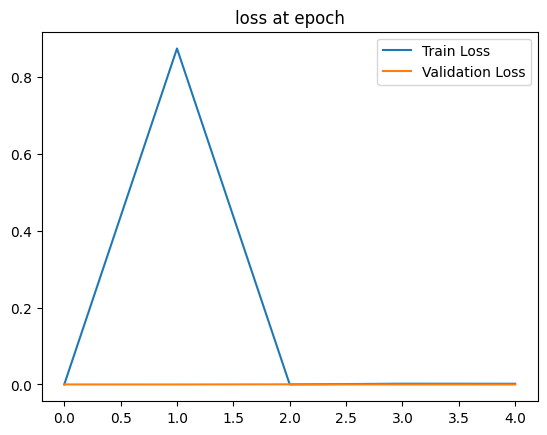

In [37]:
#graph
with torch.no_grad():
  plt.title("loss at epoch")
  plt.plot(train_losses,  label="Train Loss")
  plt.plot(test_losses,  label="Validation Loss")
  plt.legend()

In [41]:
#grab one image
model.eval()
with torch.no_grad():
  n_pred = model(test_data[2024][0].view(1,1,28,28))

In [36]:
n_pred.argmax()

tensor(7)